# Suppl. Fig. Visual Cortex Natural Images

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import pickle
from mei.modules import EnsembleModel

### Neuronal data files

make sure to copy `neuronal_responses.tar` to "./data" and extract it (using `tar -xvf neuronal_responses.tar`)

In [2]:
neuronal_data_files = ['./data/neuronal_responses/BISC_ColorImageNet_3783352485704_band_13.pickle',
 './data/neuronal_responses/BISC_ColorImageNet_3783003058075_band_14.pickle',
 './data/neuronal_responses/BISC_ColorImageNet_3783352485704_band_12.pickle',
 './data/neuronal_responses/BISC_ColorImageNet_3779890840755_band_13.pickle',
 './data/neuronal_responses/BISC_ColorImageNet_3783003058075_band_12.pickle',
 './data/neuronal_responses/BISC_ColorImageNet_3783003058075_band_11.pickle',
 './data/neuronal_responses/BISC_ColorImageNet_3779890840755_band_11.pickle',
 './data/neuronal_responses/BISC_ColorImageNet_3779890840755_band_14.pickle',
 './data/neuronal_responses/BISC_ColorImageNet_3783352485704_band_11.pickle',
 './data/neuronal_responses/BISC_ColorImageNet_3783347045492_band_14.pickle',
 './data/neuronal_responses/BISC_ColorImageNet_3783008566459_band_12.pickle',
 './data/neuronal_responses/BISC_ColorImageNet_3783347045492_band_11.pickle',
 './data/neuronal_responses/BISC_ColorImageNet_3783008566459_band_11.pickle',
 './data/neuronal_responses/BISC_ColorImageNet_3783352485704_band_14.pickle',
 './data/neuronal_responses/BISC_ColorImageNet_3783347045492_band_13.pickle',
 './data/neuronal_responses/BISC_ColorImageNet_3783008566459_band_13.pickle',
 './data/neuronal_responses/BISC_ColorImageNet_3783003058075_band_13.pickle',
 './data/neuronal_responses/BISC_ColorImageNet_3779890840755_band_12.pickle',
 './data/neuronal_responses/BISC_ColorImageNet_3783008566459_band_14.pickle',
 './data/neuronal_responses/BISC_ColorImageNet_3783347045492_band_12.pickle']

In [3]:
with open(neuronal_data_files[0], "rb") as pkl:
    neuronal_data = pickle.load(pkl)

In [4]:
neuronal_data.keys()

dict_keys(['subject_id', 'setup', 'session_start_time', 'params_id', 'fp_proc_method', 'training_image_ids', 'training_prior_image_ids', 'training_responses', 'testing_image_ids', 'testing_prior_image_ids', 'testing_responses', 'testing_repetitions', 'unit_ids', 'electrode_nums', 'x_grid_location', 'y_grid_location', 'relative_depth_microns', 'session_id'])

In [5]:
neuronal_data["training_responses"].shape # 50 channels, responses to 12510 images

(46, 12570)

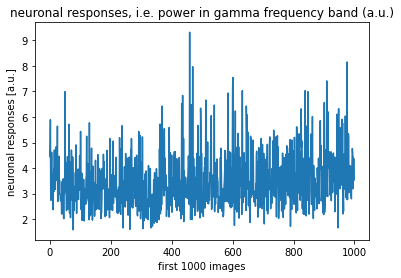

In [6]:
plt.plot(neuronal_data["training_responses"][0,:1000]) # responses of the first channel to th first n=1000 images
plt.title("neuronal responses, i.e. power in gamma frequency band (a.u.)")
plt.ylabel("neuronal responses [a.u.]")
plt.xlabel("first 1000 images");

### Natural Images

make sure to copy `natural_images.tar` to "./data" and extract it (using `tar -xvf natural_images.tar`)

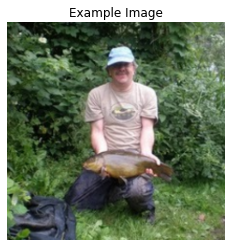

In [7]:
image_directory = "./data/images/"
example_filename = os.path.join(image_directory, "000001.npy")
image = np.load(example_filename)
plt.imshow(image)
plt.title("Example Image")
plt.axis("off");

In [8]:
from nnvision.datasets.monkey_loaders import monkey_static_loader_combined
dataset_fn = monkey_static_loader_combined
dataset_config =  {'dataset': 'CSRF19_V1',
  'neuronal_data_files': neuronal_data_files, # neuronal response directory defined above
  'image_cache_path': image_directory, # natural image directory defined above
  'crop': 0,
  'scale': 0.8,
  'seed': 1000,
  'time_bins_sum': 12,
  'batch_size': 64,
  'img_mean': 113.5,
  'img_std': 59.58}

### Instaniate pytorch dataloaders

In [9]:
dataloaders = dataset_fn(**dataset_config)
dataloaders # train/validation/test split

Files Processing: 100%|██████████| 20/20 [00:04<00:00,  4.70it/s]
/usr/local/lib/python3.8/dist-packages/skimage/_shared/utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return func(*args, **kwargs)


{'train': {'all_sessions': <torch.utils.data.dataloader.DataLoader at 0x7f075de9dd30>},
 'validation': {'all_sessions': <torch.utils.data.dataloader.DataLoader at 0x7f075deadc70>},
 'test': {'all_sessions': <torch.utils.data.dataloader.DataLoader at 0x7f075de536a0>}}

In [10]:
batch = next(iter(dataloaders["test"]["all_sessions"]))

In [11]:
batch.inputs.shape # shape of output tensor: (batch, channels, height, width)

torch.Size([35, 3, 186, 186])

In [12]:
batch.targets.shape # shape of output tensor: (batch, total response channels and frequency bands)

torch.Size([35, 1787])

### Build model: Figue panel B, model architecture

In [13]:
from nnvision.models.ptrmodels import convnext_core_gauss_readout
model_fn = convnext_core_gauss_readout
model_config = {'model_name': 'facebook/convnextv2-tiny-1k-224',
  'layer_name': 'convnextv2.encoder.stages.1.layers.1',
  'patch_embedding_stride': None,
  'fine_tune': True,
  'pretrained': True,
  'gamma_readout': 0.001,
  'final_norm': 'BatchNorm',
  'final_nonlinearity': 'GELU',
  'stack': None}

model = model_fn(dataloaders["train"], seed=0, **model_config)

/usr/local/lib/python3.8/dist-packages/skimage/_shared/utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return func(*args, **kwargs)


## Trainer

In [14]:
from nnvision.training.trainers import convnext_finetune_trainer
trainer_fn = convnext_finetune_trainer
trainer_config = {'stop_function': 'get_correlations',
  'maximize': True,
  'avg_loss': False,
  'device': 'cuda',
  'max_iter': 200, # set to 100 for recreating the full model. 1 iter is set to demonstrate the code
  'lr_init': 0.001,
  'lr_decay_steps': 4,
  'patience': 4,
  'verbose': True,
  'adamw': True,
  'min_lr': 1e-08,
  'lr_decay_factor': 0.1,
  'initial_n_epochs': 30}

### Run model training

for all following cells, a CUDA GPU device is required
- in this example script, the training run is interrupted afte the first epoch


In [17]:
training_output = trainer_fn(model, dataloaders, seed=0, **trainer_config)

Epoch 1:   5%|▌         | 16/292 [01:15<21:47,  4.74s/it]


KeyboardInterrupt: 

# Load model from checkpoints

make sure to copy `model_checkpoints.tar` to "./data" and extract it (using `tar -xvf model_checkpoints.tar`)

In [15]:
base_dir = ("./data/model_checkpoints/")
filename = os.path.join(base_dir, "486b169de065684d812a0c59229292f0.pth.tar")
state_dict = torch.load(filename)


data_info = {
    "all_sessions": {
        "input_dimensions": torch.Size([64, 3, 186, 186]),
        "input_channels": 3,
        "output_dimension": 1787,
        "img_mean": 113.5,
        "img_std": 59.58,
    },
}

# load single model
model = model_fn(
    seed=0,
    dataloaders=None,
    **model_config,
    data_info=data_info,
)
model.load_state_dict(state_dict)

## Load model ensemble
ensemble_names = [
    "705bc4028ccd4eb0636d0a06554c39ae.pth.tar",
    "8e4a82426338a1180287424c4e62ba0e.pth.tar",
    "94a1ac3a3b2316267928038d42defae5.pth.tar",
    "a3fdf82f6bcb640040fa313bd892faa0.pth.tar",
]

ensemble_models = []
ensemble_models.append(model)

for f in ensemble_names:
    ensemble_filename = os.path.join(base_dir, f)
    ensemble_state_dict = torch.load(ensemble_filename)
    ensemble_member = model_fn(
        seed=0,
        dataloaders=None,
        **model_config,
        data_info=data_info,
    )
    ensemble_member.load_state_dict(ensemble_state_dict)
    ensemble_models.append(ensemble_member)

# Ensemble model
model_ensemble = EnsembleModel(*ensemble_models)
model_ensemble.eval().cuda();

<ipython-input-15-ae6474a9cc6f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename)
<ipython-input-15-ae6474a9cc6f>:38: FutureWarning: You are

# Use model to make predictions

In [16]:
id_in_model = [382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394,
        395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407,
        408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420,
        421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433,
        434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446,
        447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459,
        460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472,
        473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485,
        486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498,
        499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511,
        512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524,
        525, 526]

id_in_session = [  1,   2,   4,  17,  18,  19,  20,  22,  24,  25,  27,  29,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  43,  47,  49,  50,  51,
        52,  53,  55,  56,  57,  58,  61,  66,  67,  68,  71,  72,  73,
        74,  75,  81,  82,  83,  84,  85,  88,  89,  93,  97,  98,  99,
       100, 101, 102, 103, 104, 109, 113, 114, 115, 117, 118, 120, 122,
       123, 124, 125, 127, 129, 130, 131, 135, 136, 137, 138, 139, 140,
       141, 146, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       163, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 191, 193, 195,
       197, 198, 200, 201, 202, 203, 204, 205, 206, 207, 210, 211, 218,
       219, 220, 223, 231, 233, 234, 235, 236, 237, 238, 239, 240, 251,
       254, 255]


In [17]:
from nnvision.utility.measures import get_explainable_var, get_avg_correlations

explainable_variance = get_explainable_var(dataloaders["test"])
model_accuracy_correlations = get_avg_correlations(model_ensemble, dataloaders["test"])

/usr/local/lib/python3.8/dist-packages/nnvision/utility/measures.py:500: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(repeated_inputs), repeated_outputs


In [18]:
model_accuracy_correlations.mean()

0.6466298671230277

### get explainable variance and correlation_accuracy

In [19]:
### bisc recording settings:
bisc_h = 16
bisc_w = 16
all_ids = np.arange(1, bisc_h*bisc_w + 1)
idx_filter = np.isin(all_ids, id_in_session)

In [20]:
r1, r2 = (explainable_variance[id_in_model], model_accuracy_correlations[id_in_model])

fev_array = np.ones((bisc_h,bisc_w,))
n_plot=0
for i in range(bisc_h*bisc_w):
    if idx_filter[i]:
        fev_array[i//bisc_h, i%bisc_h] = r1[n_plot]
        n_plot +=1
    else:
        fev_array[i//bisc_h, i%bisc_h] = np.nan
        
corr_array = np.ones((bisc_h, bisc_w,))
n_plot=0
for i in range(bisc_h*bisc_w):
    if idx_filter[i]:
        corr_array[i//bisc_w, i%bisc_w] = r2[n_plot]
        n_plot +=1
    else:
        corr_array[i//bisc_w, i%bisc_w] = np.nan

### Show explainable variance across the array
#### Panel D, Suppl. Fig. Natural Image Analysis

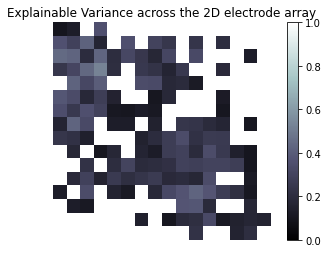

In [21]:
plt.imshow(fev_array, cmap="bone", vmin=0, vmax=1)
plt.colorbar()
plt.axis("off");
plt.title("Explainable Variance across the 2D electrode array");

### Show model accuracy across the array )
#### Panel D, Suppl. Fig. Natural Image Analysis

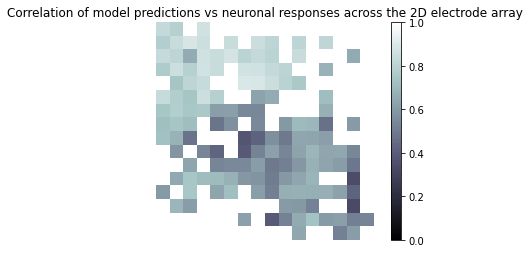

In [22]:
plt.imshow(corr_array, cmap="bone", vmin=0, vmax=1)
plt.colorbar()
plt.axis("off")
plt.title("Correlation of model predictions vs neuronal responses across the 2D electrode array");

# Generate maximally Exciting inputs

In [23]:
from mei.modules import ConstrainedOutputModel
from mei.methods import gradient_ascent

mei_config = {'initial': {'path': 'mei.initial.RandomNormal'},
  'optimizer': {'path': 'torch.optim.SGD', 'kwargs': {'lr': 5}},
  'precondition': {'path': 'mei.legacy.ops.GaussianBlur',
   'kwargs': {'sigma': 4}},
  'postprocessing': {'path': 'nnvision.mei.ops.ChangeNormAndClip',
   'kwargs': {'norm': 20, 'x_min': -1.8, 'x_max': 1.8}},
  'stopper': {'path': 'mei.stoppers.NumIterations',
   'kwargs': {'num_iterations': 1000}},
  'objectives': [{'path': 'mei.objectives.EvaluationObjective',
    'kwargs': {'interval': 10}}],
  'device': 'cuda'}

# fig 2F, MEIs from the top left recording channel to bottom right
index = id_in_model[0] # top left - recording channels above area V1
# index = id_in_model[-1] # bottom right - recording channels above area V4
constrained_model = ConstrainedOutputModel(model_ensemble, constraint=index, forward_kwargs=dict(data_key="all_sessions"))

In [24]:
output = gradient_ascent(dataloaders, constrained_model, mei_config, seed=42)

Using a transparency weight of 1.0


### Panel G - top left MEI

(-0.5, 185.5, 185.5, -0.5)

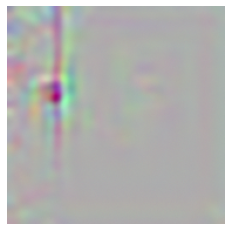

In [25]:
mei = output[0]
mei = (mei-mei.min()) / (mei.max() - mei.min())
plt.imshow(mei[0].permute(1,2,0))
plt.axis("off")

Text(0, 0.5, 'MEI activation (a.u.)')

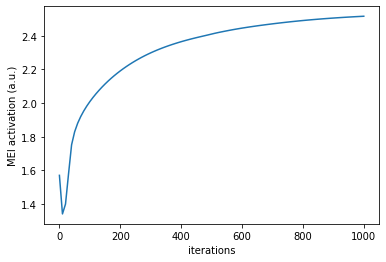

In [26]:
times = output[2]['mei.objectives.EvaluationObjective']["times"]
values = output[2]['mei.objectives.EvaluationObjective']["values"]
plt.plot(times, values)
plt.xlabel("iterations")
plt.ylabel("MEI activation (a.u.)")

In [27]:
# fig 2F, MEIs from the top left recording channel to bottom right
#index = id_in_model[0] # top left - recording channels above area V1
index = id_in_model[-1] # bottom right - recording channels above area V4
constrained_model = ConstrainedOutputModel(model_ensemble, constraint=index, forward_kwargs=dict(data_key="all_sessions"))
output = gradient_ascent(dataloaders, constrained_model, mei_config, seed=42)

Using a transparency weight of 1.0


### Panel G - bottom right MEI

(-0.5, 185.5, 185.5, -0.5)

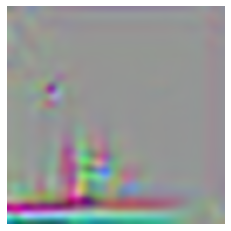

In [28]:
mei = output[0]
mei = (mei-mei.min()) / (mei.max() - mei.min())
plt.imshow(mei[0].permute(1,2,0))
plt.axis("off")